In [63]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import diags_array,identity, kron
from scipy.sparse.linalg import splu


# https://pages.cs.wisc.edu/~chaol/data/cs777/stam-stable_fluids.pdf
# https://cg.informatik.uni-freiburg.de/intern/seminar/gridFluids_GPU_Gems.pdf

def navier_stokes(x_range, n, t_max, iters, init_U_func, F, samples,viscosity=-10):
    dx = (x_range[1] - x_range[0]) / n
    dt = t_max / iters
    sample_freq = iters//samples
    # this is going to be the matrix that we use to capture "snapshots" of U throughout our simulation
    V = np.zeros((samples + 1, n, n), dtype=(float,2))
    # this is the matrix that we will use to track the velocity of each discrete chunk of our simulation 
    U = np.zeros((3, n, n), dtype=(float,2))
    #sample_freq = iters/
    U[0] = np.array([[init_U_func(x_range[0] + dx*i, x_range[0] + dx*j) for i in range(n)] for j in range(n)])
    U[1] = U[0]
    # save our first sample
    V[0] = U[0]
    # construct indices for U
    col_idx, row_idx = np.meshgrid(np.arange(0, U.shape[1]), np.arange(0, U.shape[2]))

    # make a matrix representing the descretized laplace operator:
    # https://en.wikipedia.org/wiki/Discrete_Poisson_equation
    # we have to decrement n because we will only be solving for our simulation's INTERIOR points. The boundary points
    # will be adjusted later in accordance with a boundary condition
    n -= 2
    diagonals = [
        [4] * n,
        [-1] * (n-1),
        [-1] * (n-1)
    ]
    offsets = np.array([0,1,-1])
    # this is the block triangular matrix that will compose the poisson matrix
    D_sparse = diags_array(diagonals, offsets=offsets, format='csc')
    offdiag1 = diags_array([[-1] * (n**2 - n)], offsets=[n], format='csc')
    offdiag2 = diags_array([[-1] * (n**2 - n)], offsets=[-n], format='csc')
    # construct our final poisson matrix using a kronecker product
    # https://en.wikipedia.org/wiki/Kronecker_product
    poisson_mat_sparse = kron(identity(n), D_sparse, format='csc') + offdiag1 + offdiag2
    poisson_mat_sparse /= -(dx*dx)
    # calculate the inverse of our poisson matrix this will make solving this system repeatedly very easy
    poisson_inv = splu(poisson_mat_sparse)

    # make a matrix representing the implicit diffusion step:
    sparse_diffusion_matrix = identity(n*n, format='csc') - viscosity*dt*poisson_mat_sparse
    # find its inverse (we will be solving this system repeatedly, so this makes sense)
    diffusion_inv = splu(sparse_diffusion_matrix)
    # increment n back to what it was.
    n+=2
    # run our simulation
    for i in tqdm(range(0, iters), total=iters, desc="Navier-Stokes Solver"):
        W1 = U[1]
        U[2] = W1
        ########################################    ADVECTION    ################################################
        # find the index of each particle's velocity one step ago:
        row_shift = row_idx[1:-1, 1:-1] - W1[1:-1, 1:-1, 0] * dt / dx
        col_shift = col_idx[1:-1, 1:-1] - W1[1:-1, 1:-1, 1] * dt / dx
        row_shift = np.around(row_shift,0)
        col_shift = np.around(col_shift,0)
        
        # make sure that we aren't looking off the edge of the simulation. It should use boundary conditions in the case where the velocity is too far away
        row_shift = np.clip(row_shift.astype(int), 0, W1.shape[0] - 1)
        col_shift = np.clip(col_shift.astype(int), 0, W1.shape[1] - 1)
        # update our velocity in accordance with advection
        U[2, 1:-1, 1:-1]= W1[row_shift, col_shift]
        W2 = U[2]
        force =  F(x_range[0] + row_idx*dx, x_range[0] + col_idx*dx, i*dt)
        W2[:, :, 0] += force[0]
        W2[:, :, 1] += force[1]
        #######################################     DIFFUSION     #################################################
        # implicit derivation yayy:
        W2_x = diffusion_inv.solve(W2[1:-1, 1:-1, 0].flatten('C')).reshape(W2[1:-1, 1:-1, 0].shape, order='C')
        W2_y = diffusion_inv.solve(W2[1:-1, 1:-1, 1].flatten('C')).reshape(W2[1:-1, 1:-1, 1].shape, order='C')
        #print(np.sum(np.abs(W2_x - W2_x_cg)))
        W2[1:-1, 1:-1, 0] = W2_x
        W2[1:-1, 1:-1, 1] = W2_y
        
        U[2] = W2
        ######################################      PROJECTION     ######################################################
        W3 = U[2]
        # calculate pressure using the poisson pressure equation
        div_W3 = ((W3[2:, 1:-1, 0] - W3[0:-2, 1:-1, 0]) / (2*dx)) + ((W3[1:-1, 2:, 1] - W3[1:-1, :-2, 1]) /(2*dx))
        # solve for our pressure field
        p = poisson_inv.solve(div_W3.flatten('C')).reshape(div_W3.shape, order='C')
        # find the gradient of our pressure field
        div_px = (p[2:, 1:-1] - p[0:-2, 1:-1])/(2*dx)
        div_py = (p[1:-1, 2:] - p[1:-1, 0:-2])/(2*dx)
        div_p = np.dstack((div_px, div_py))

        W4 = W3[2:-2, 2:-2] - div_p
        U[2, 2:-2, 2:-2] = W4
        
        # update our boundary conditions
        U[2, 0, 2:-2] = U[2, 1, 2:-2] # top boundary
        U[2, -1, 2:-2] = U[2, -2, 2:-2] # bottom boundary
        U[2, 2:-2, 0] = U[2, 2:-2, 1] # left boundary
        U[2, 2:-2, -1] = U[2, 2:-2, -2]  # right boundary

        # shift 
        U[0] = U[1]
        U[1] = U[2]
        # if its time to save a sample, do it
        if i % sample_freq == 0:
            V[int(i // sample_freq)+1] = U[1]

    return V

def F (x,y,t): 
    #res = (np.cos(t*5)*x, np.cos(t*5)*y)
    interval = 5 * np.pi/0.01 
    return ( 1 - ((x/100)*np.sin(t*interval)), 1 - (y/100*np.sin(t*interval)) )


## Define forcing functions

In [131]:
def pulse_func(X, Y, t, pulse_period=0.03, pulse_amplitude=100, pulse_duration=0.1, width=0.2):
    """
    Generate periodic pulses from the center of the domain.

    Args:
        x (np.ndarray): X-coordinates of the domain.
        y (np.ndarray): Y-coordinates of the domain.
        t (float): Current time step.
        domain_size (float): Size of the domain.
        n (int): Number of grid points in each dimension.
        pulse_period (float): Period of the pulses.
        pulse_amplitude (float, optional): Amplitude of the pulses. Default is 1.0.
        pulse_width (float, optional): Width of the pulses as a fraction of the domain size. Default is 0.2.

    Returns:
        tuple: A tuple containing the x and y components of the velocity field.
    """

    u = np.zeros_like(X)
    v = np.zeros_like(Y)

    if t > 0.2:
        return u, v

    pulse_radius = pulse_width * X[-1][-1] / 2
    pulse_center_x = pulse_center_y = 0.25

    # calculate the distance from the center
    dist = np.sqrt((X - pulse_center_x)**2 + (Y - pulse_center_y)**2)

    # generate pulses
    pulse_phase = t/0.3  # Normalize time to [0, 1) range
    #print(pulse_phase)
    pulse_strength = pulse_amplitude * np.exp(-((pulse_phase - 0.5) / (0.5 * pulse_duration))**2)
    pulse_phase = t/1  # Normalize time to [0, 1) range
    pulse_strength += pulse_amplitude * np.exp(-((pulse_phase - 0.5) / (0.5 * pulse_duration))**2)

    #print(t, pulse_strength)
    pulse_mask = (dist < pulse_radius)


    u[pulse_mask] = pulse_strength
    v[pulse_mask] = pulse_strength


    pulse_center_x = pulse_center_y = -0.15
    # calculate the distance from the center
    dist = np.sqrt((X - pulse_center_x)**2 + (Y - pulse_center_y)**2)
    pulse_strength = pulse_amplitude * np.exp(-((pulse_phase - 0.5) / (0.5 * pulse_duration))**2)
    pulse_mask = (dist < pulse_radius)
    u[pulse_mask] = pulse_strength
    v[pulse_mask] = pulse_strength


    return u, v

no_force = lambda t,x,y: (np.zeros_like(x), np.zeros_like(y))

def circ(X, Y, t, t_max=3, amplitude=5, width=0.06):
    u = np.zeros_like(X)
    v = np.zeros_like(Y)
    mag = np.sqrt(X**2 + Y**2)


    pulse_center_x = 0.4*np.cos(t *2* np.pi/t_max)
    pulse_center_y = 0.4*np.sin(t *2* np.pi/t_max)
    dist = np.sqrt((X - pulse_center_x)**2 + (Y - pulse_center_y)**2)
    pulse_mask = (dist < width)
    u[pulse_mask] = -X[pulse_mask] * amplitude / np.clip(mag[pulse_mask], a_min=0.01, a_max=None)
    v[pulse_mask] = -Y[pulse_mask] * amplitude / np.clip(mag[pulse_mask], a_min=0.01, a_max=None)
    

    pulse_center_x = -0.5*np.sin(0.5*t*np.pi/t_max)
    pulse_center_y = -0.5*np.cos(0.5*t*np.pi/t_max)
    dist = np.sqrt((X - pulse_center_x)**2 + (Y - pulse_center_y)**2)
    pulse_mask = (dist < width)
    u[pulse_mask] = -X[pulse_mask] * amplitude / np.clip(mag[pulse_mask], a_min=0.01, a_max=None)
    v[pulse_mask] = -Y[pulse_mask] * amplitude / np.clip(mag[pulse_mask], a_min=0.01, a_max=None)
    
    

    pulse_center_x = 0.9*np.sin(t *np.pi/t_max)
    pulse_center_y = 0.9*np.cos(t *np.pi/t_max)
    dist = np.sqrt((X - pulse_center_x)**2 + (Y - pulse_center_y)**2)
    pulse_mask = (dist < width)
    u[pulse_mask] = -X[pulse_mask] * amplitude / np.clip(mag[pulse_mask], a_min=0.01, a_max=None)
    v[pulse_mask] = -Y[pulse_mask] * amplitude / np.clip(mag[pulse_mask], a_min=0.01, a_max=None)
    
    return u,v

    
def corners(X, Y, t_max=3, amplitude=0.3, width=0.1):
    u = np.zeros_like(X)
    v = np.zeros_like(Y)
    mag = np.sqrt(X**2 + Y**2)

    for center_x, center_y in [(0.7,1), (1, 0.6), (-0.5, -1), (0.7, -1), (-1, 0.75)]:
        dist = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
        pulse_mask = (dist < width)
        u[pulse_mask] = -X[pulse_mask] * amplitude / np.clip(mag[pulse_mask], a_min=0.01, a_max=None)
        v[pulse_mask] = -Y[pulse_mask] * amplitude / np.clip(mag[pulse_mask], a_min=0.01, a_max=None)
        
    return u,v


## Run the simulation

In [132]:
x_range = (-1,1)
iters = samples = 200
n = 200
viscosity = 0.0001
t_max = 20
dt = t_max / iters

dx = (x_range[1] - x_range[0]) / n
dt = t_max / iters
print(dt/dx)
V = navier_stokes(x_range=x_range, n=n, t_max=t_max, iters=iters, samples=samples, viscosity=viscosity, F=corners, init_U_func=lambda x,y: (-y,x))

10.0


Navier-Stokes Solver: 100%|██████████| 200/200 [00:05<00:00, 37.51it/s]


## Trace particles through the simulation using Runge-Kutta

C:\Users\alexm\AppData\Local\Temp\ipykernel_2412\2766597769.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = max(min(int(np.round(y[0]/dx)), V.shape[1]-1),0)
C:\Users\alexm\AppData\Local\Temp\ipykernel_2412\2766597769.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = max(min(int(np.round(y[0]/dx)), V.shape[2]-1),0)


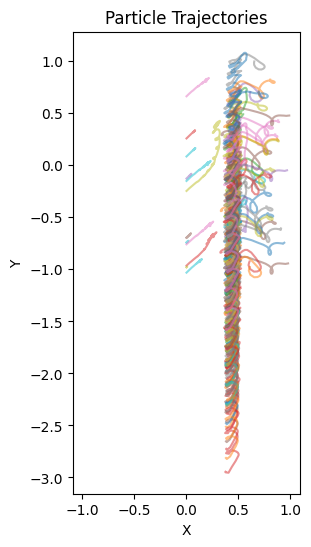

In [5]:
from scipy.integrate import solve_ivp
particles = 100
dx = (x_range[1] - x_range[0]) / n
dt = t_max/n

def f(t_real,y):
    t = max(min(int(np.round(t_real/dt)), V.shape[0]-1),0)
    x1 = max(min(int(np.round(y[0]/dx)), V.shape[1]-1),0)
    x2 = max(min(int(np.round(y[0]/dx)), V.shape[2]-1),0)
    res = V[t,x1,x2]
    return res



trajectories = []
for i in range(particles):
    y0 = np.random.uniform(low=x_range[0], high=x_range[1], size=2)
   # print(y0)
    traj = solve_ivp(f, t_span=(0,t_max), y0=y0, vectorized=True, max_step=0.1).y
    trajectories.append(traj)


fig, ax = plt.subplots(figsize=(8, 6))
#print(trajectories)
for i in range(particles):
    x = trajectories[i][0]
    y = trajectories[i][1]
    ax.plot(x, y, '-', alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Particle Trajectories')
ax.set_aspect('equal')  # Set equal aspect ratio for better visualization
plt.show()


## View the result in the interactive viewer

In [133]:
from ipywidgets import interact
from matplotlib.animation import FuncAnimation
import matplotlib
# Set up the figure and axis
def animate(frame):
    #ax.clear()
    X, Y = np.meshgrid(np.linspace(x_range[0], x_range[1], V.shape[2]), np.linspace(x_range[0], x_range[1], V.shape[1]))
    V_frame = V[frame]
    V_x, V_y = V_frame[:, :, 0], V_frame[:, :, 1]
    norm = np.sqrt(V_x**2 + V_y**2)  # Calculate the magnitude of the vectors
    
    # Plot the vector field magnitude
    plt.imshow(norm, cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'T: {np.round(frame*dt*iters/samples, 1)}s  KE: {np.round(0.5*np.sum(norm**2)*(dx**2), 1)} joules')
    plt.colorbar()

interact(animate, frame=(0, V.shape[0]-1, 2))


interactive(children=(IntSlider(value=100, description='frame', max=200, step=2), Output()), _dom_classes=('wi…

<function __main__.animate(frame)>

## Save the result as an mp4 (if it's good)

In [ ]:
from matplotlib.animation import writers
import matplotlib
# Set up the figure and axis
matplotlib.use('Agg')  # Use the Agg backend for rendering
dpi = 100  # Desired resolution (dots per inch)
width, height = 1080, 1080  # Full HD resolution (adjust as needed)
fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1], frameon=False)  # Add axes spanning the entire figure

# Function to plot each frame
def animate(frame):
    frame //= 2
    ax.clear()
    X, Y = np.meshgrid(np.linspace(x_range[0], x_range[1], V.shape[2]), np.linspace(x_range[0], x_range[1], V.shape[1]))
    V_frame = V[frame]
    V_x, V_y = V_frame[:, :, 0], V_frame[:, :, 1]
    norm = np.sqrt(V_x**2 + V_y**2)  # Calculate the magnitude of the vectors
    
    # Plot the vector field magnitude
    im = ax.imshow(norm, cmap='viridis', extent=[x_range[0], x_range[1], x_range[0], x_range[1]], vmax=8)
    ax.set_axis_off()
    #ax.set_xlabel('X')
    #ax.set_ylabel('Y')
    #ax.set_title(f'T: {np.round(frame*dt*iters/samples, 4)}s  KE: {np.round(0.5*np.sum(norm**2)*(dx**2), 3)} joules')

ani = FuncAnimation(fig, animate, frames=(V.shape[0]-1))

# Save the animation as a GIF
Writer = writers['ffmpeg']
writer = Writer(fps=60, metadata=dict(artist='Me'), bitrate=1000)
ani.save('vector_field_magnitudes3.mp4', writer=writer)


In [ ]:
import sys
sys.getsizeof(V)/1e6

2562.56016

## Testing

In [ ]:
n+=2
D = np.diag(-4 * np.ones(n-2)) + np.diag(np.ones(n-3), -1) + np.diag(np.ones(n-3), 1) 
poisson_mat = np.kron(np.eye(n-2), D) 
poisson_mat += np.diag(np.ones(poisson_mat.shape[1] - D.shape[1]), D.shape[1])
poisson_mat += np.diag(np.ones(poisson_mat.shape[0] - D.shape[0]), -D.shape[0]) 
lu_res = np.linalg.solve(poisson_mat, b) 


In [ ]:
from scipy.sparse import diags_array,identity, kron
from scipy.sparse.linalg import spilu, cg, bicgstab, LinearOperator
import numpy as np
import time
n=500

# D = np.diag(-4 * np.ones(n-2)) + np.diag(np.ones(n-3), -1) + np.diag(np.ones(n-3), 1)
# poisson_mat = np.kron(np.eye(n-2), D)
# poisson_mat += np.diag(np.ones(poisson_mat.shape[1] - D.shape[1]), D.shape[1])
# poisson_mat += np.diag(np.ones(poisson_mat.shape[0] - D.shape[0]), -D.shape[0])
# lu_solve = np.linalg.solve(poisson_mat, b)
n -= 2
N = n*n
b = np.random.uniform(low=-1, high=1, size=N)
diagonals = [
    [4] * n,
    [-1] * (n-1),
    [-1] * (n-1)
]
offsets = np.array([0,1,-1])
D_sparse = diags_array(diagonals, offsets=offsets, format='csc')
offdiag1 = diags_array([[-1] * (n**2 - n)], offsets=[n], format='csc')
offdiag2 = diags_array([[-1] * (n**2 - n)], offsets=[-n], format='csc')
poisson_mat_sparse = kron(identity(n), D_sparse, format='csc') + offdiag1 + offdiag2

start = time.time()
# https://stackoverflow.com/questions/46876951/sparse-matrix-solver-with-preconditioner
lu = splu(poisson_mat_sparse)
cg_solve = bicgstab(A=poisson_mat_sparse, b=b)[0]

print(f'cg solve in {time.time() - start}')
#print(f'summed diff: {np.sum(np.abs(cg_solve) - np.abs(lu_solve))}')

In [ ]:
A = np.array([
    [[-1,-1], [0,0], [0,0]],
    [[0,0], [-1,-1], [1,-1]],
    [[0,0], [0,0], [0,1]]
])
idx= np.mgrid[0:A.shape[0], 0:A.shape[1]]
print(idx)
#print(col_idx)
#print(A[:,:,1])
shift = idx - A[:,:]
# update our velocity in accordance with advection
A[shift]


AttributeError: 'NoneType' object has no attribute 'step'